In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [3]:
plt.rcParams['figure.figsize'] = (15, 10)

In [23]:
def novidade_energia(x, fs, w, log=False):
    x_quadrado = x**2
    E = np.convolve(x_quadrado, w, 'same')
    
    if log:
        E = np.log(E)
    
    E_diff = np.diff(E)
    E_diff = np.concatenate((E_diff, np.array([0.])))
    E_diff[E_diff < 0] = 0

    return E_diff    

def novidade_espectro(x, fs, N, H,compressao_log=False, gamma=100):
    w = sp.signal.hann(N)
    X = librosa.stft(x, n_fft=N, win_length=N, hop_length=H, window=w)
    Y = np.abs(X)
    
    if compressao_log:
        Y = np.log(1 + gamma*Y)
    
    Y_diff = np.diff(Y)
    Y_diff[Y_diff < 0] = 0
    fc_novidade = np.sum(Y_diff, axis=0)
    fc_novidade = np.concatenate((fc_novidade, np.array([0.])))
    
    return fc_novidade

def novidade_fase(x, fs, N, H):
    w = sp.signal.hann(N)
    X = librosa.stft(x, n_fft=N, win_length=N, hop_length=H, window=w)
    phi = np.angle(X)/(2*np.pi)
    
    # phase unwrapping (aplicação da função de argumento principal)
    argumento_principal = lambda x: np.mod(x + 0.5 , 1) - 0.5
    
    # primeira derivada
    phi_diff = np.diff(argumento_principal(phi))
    # segunda derivada 
    phi_diff_2 = np.diff(argumento_principal(phi_diff))
    
    fc_novidade = np.sum(np.abs(phi_diff_2), axis=0)
    # a concatenação nesse caso tem que ter duas posições porque
    # aplicamos o diff duas vezes
    fc_novidade = np.concatenate((fc_novidade, np.array([0., 0.])))
    return fc_novidade

def novidade_complexo(x, fs, w, compressao_log=False):
    return "ops"

In [5]:
x, fs = librosa.load(librosa.util.example('trumpet'))

# Energia

In [6]:
N = 1024
w = sp.signal.hann(N)

nov_energia = novidade_energia(x, fs, w)
nov_energia_log = novidade_energia(x, fs, w, log=True)

Text(0.5, 1.0, 'Função novidade baseada em energia')

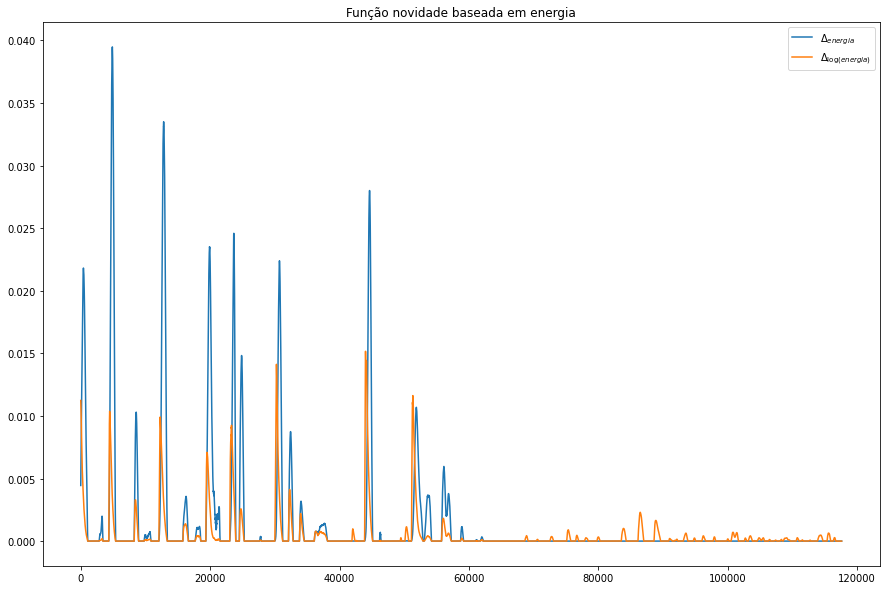

In [7]:
plt.plot(nov_energia, label='$\Delta_{energia}$')
plt.plot(nov_energia_log, label='$\Delta_{\log{(energia)}}$')
plt.legend()
plt.title('Função novidade baseada em energia')

# Espectro

In [8]:
N = 1024
H = 256

nov_espectro = novidade_espectro(x, fs, N, H, False)
nov_espectro_1 = novidade_espectro(x, fs, N, H, True, 1)
nov_espectro_10 = novidade_espectro(x, fs, N, H, True, 10)
nov_espectro_100 = novidade_espectro(x, fs, N, H, True, 100)

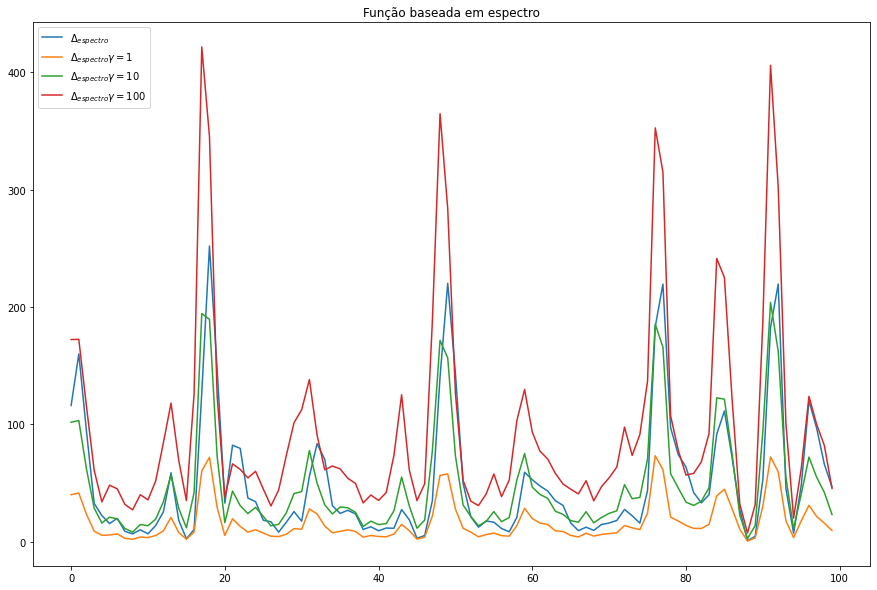

In [20]:
plt.plot(nov_espectro[0:100], label='$\Delta_{espectro}$')
plt.plot(nov_espectro_1[0:100], label='$\Delta_{espectro} \gamma=1$')
plt.plot(nov_espectro_10[0:100], label='$\Delta_{espectro} \gamma=10$')
plt.plot(nov_espectro_100[0:100], label='$\Delta_{espectro} \gamma=100$')
plt.title('Função baseada em espectro')
plt.legend()
plt.savefig('nov_espectro.png')

# Fase

In [11]:
X = librosa.stft(x, n_fft=N, win_length=N, window=w, hop_length=H)

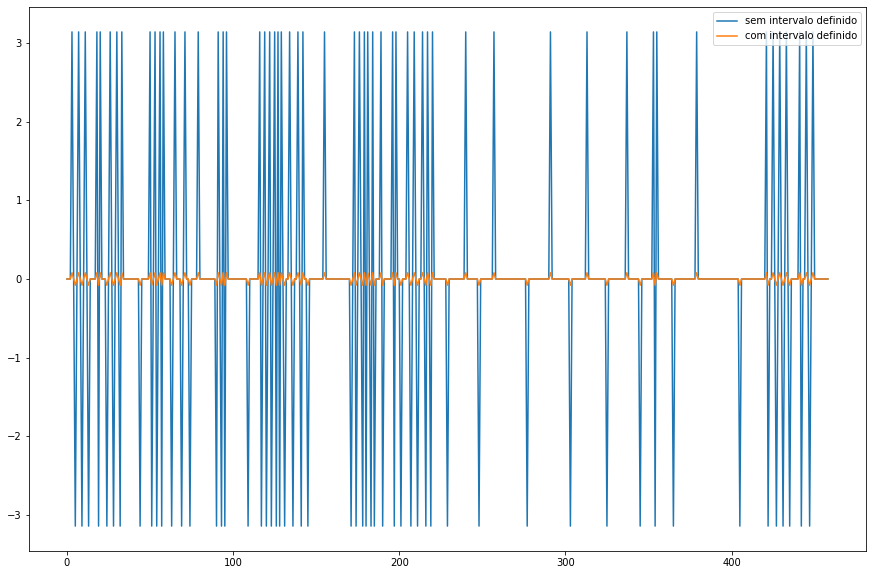

In [19]:
phi = np.angle(X)
phi_2pi = phi/(2*np.pi)
diff = np.diff(phi)
diff_2pi = np.diff(phi_2pi)
plt.plot(diff[0], label="sem intervalo definido")
plt.plot(diff_2pi[0]/(2*np.pi), label="com intervalo definido")
plt.legend()

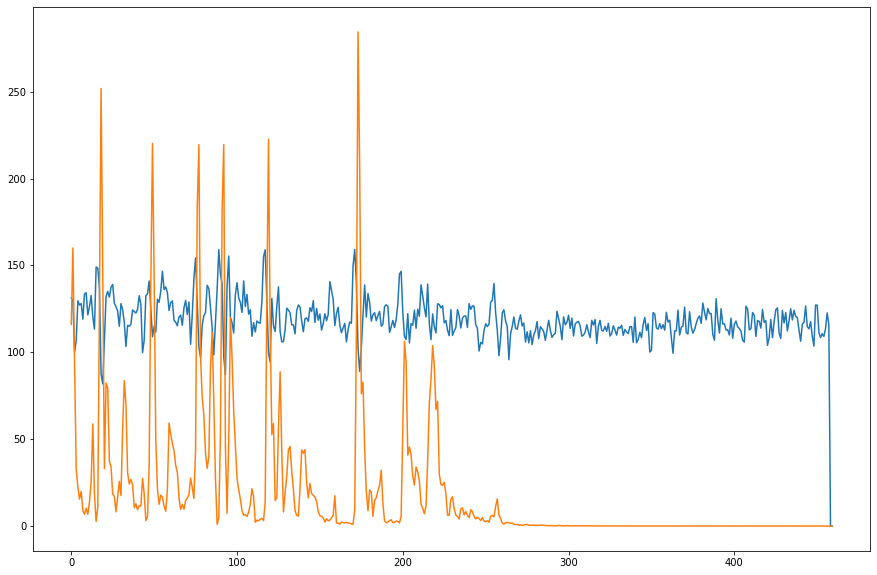

In [27]:
nov_fase = novidade_fase(x, fs, N, H)
plt.plot(nov_fase)
plt.plot(nov_espectro)

# Complexo